In [2]:
import pathlib
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import re


# Methods to calculate svd
from numpy.linalg import svd

In [3]:
DATA_PATH = "../data/TwitterNetworks/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.edgelist"))

In [4]:
unique_names = set()
for file in DATA_FILES:
    match = re.match(r"(.*?)(?:_p[123])?\.edgelist", file.name)
    if match:
        unique_names.add(match.group(1))

name_variants = {name: [] for name in unique_names}
for file in DATA_FILES:
    name_variant = file.stem.split('_')
    name_variants[name_variant[0]].append(name_variant[1])   
        

# Filter names to only those that have more than one variant
name_variants = {name: variants for name, variants in name_variants.items() if len(variants) > 1}
name_variants

{'eduskuntavaalit2019': ['p1', 'p2'],
 'digitalisaatio': ['p1', 'p2', 'p3'],
 'politiikka': ['p1', 'p2', 'p3'],
 'hyvinvointi': ['p1', 'p2', 'p3'],
 'turvallisuus': ['p1', 'p2', 'p3'],
 'osaaminen': ['p2', 'p3'],
 'eduskunta': ['p2', 'p3'],
 'ilmastonmuutos': ['p1', 'p2', 'p3'],
 'journalismi': ['p1', 'p2', 'p3'],
 'suomi': ['p1', 'p2', 'p3'],
 'luonto': ['p1', 'p2', 'p3'],
 'tutkimus': ['p1', 'p2', 'p3'],
 'sak': ['p1', 'p2', 'p3'],
 'CENTRE': ['p1', 'p2', 'p3'],
 'poliisi': ['p1', 'p2', 'p3'],
 'EDUCATION': ['p1', 'p2', 'p3'],
 'euvaalit2019': ['p2', 'p3'],
 'liikenne': ['p1', 'p2', 'p3'],
 'mielenterveys': ['p1', 'p2', 'p3'],
 'CLIMATE': ['p1', 'p2', 'p3'],
 'translaki': ['p1', 'p2'],
 'vaalit': ['p1', 'p2'],
 'työllisyys': ['p1', 'p2', 'p3'],
 'nuoret': ['p1', 'p2', 'p3'],
 'koulutus': ['p1', 'p2', 'p3'],
 'maahanmuutto': ['p1', 'p2', 'p3'],
 'viestintä': ['p1', 'p2', 'p3'],
 'lapset': ['p1', 'p2', 'p3'],
 'LEFT': ['p1', 'p2', 'p3'],
 'ECONOMICPOLICY': ['p1', 'p2', 'p3'],
 'sananva

In [5]:
from functools import partial
import concurrent.futures as cf

try:
    from joblib import Parallel, delayed 
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

# Computes the full SVD of matrix A and returns the top k singular values.
def truncated_svd(A, k=None, include_u_v=False):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    if include_u_v:
        U, _, Vh = svd(A, full_matrices=False)
        return S_k, U[:, :k], Vh[:k, :]
    return S_k


# Computes the log-likelihood for a given q
def compute_ll_for_q(sv: np.ndarray, p: int, q: int):
    q = int(q)
    S1 = sv[:q]
    S2 = sv[q:]

    if len(S2) == 0 or p <= 2:
        return (q, float(-np.inf))

    mu1 = np.mean(S1) if len(S1) else 0.0
    mu2 = np.mean(S2) if len(S2) else 0.0

    if len(S1) > 1:
        s1_squared = np.var(S1, ddof=1)
    else:
        s1_squared = 0.0

    if len(S2) > 1:
        s2_squared = np.var(S2, ddof=1)
    else:
        s2_squared = 0.0

    sigma2 = ((q - 1) * s1_squared + (p - q - 1) * s2_squared) / (p - 2)
    if not np.isfinite(sigma2) or sigma2 <= 0:
        return (q, float(-np.inf))

    sigma = np.sqrt(sigma2)

    ll = 0.0
    if len(S1):
        ll += float(np.sum(norm.logpdf(S1, mu1, sigma)))
    if len(S2):
        ll += float(np.sum(norm.logpdf(S2, mu2, sigma)))

    return (q, ll)

# Estimate the embedding dimension using the profile likelihood method
def embedding_dimension(singular_values, k=None, n_jobs: int = -1):
    
    if k is None:
        k = len(singular_values)

    sv = np.array(singular_values[:k], dtype=float)
    p = len(sv)

    if p <= 2:
        return 1

    qs = list(range(1, p))

    if n_jobs == 1:
        best_ll = float(-np.inf)
        d_hat = 1
        for q in qs:
            _, ll = compute_ll_for_q(sv, p, q)
            if ll > best_ll:
                best_ll = ll
                d_hat = q
        return d_hat

    if _HAVE_JOBLIB:
        results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_ll_for_q)(sv, p, q) for q in qs
        )
    else:
        max_workers = None if n_jobs in (None, -1) else int(n_jobs)
        func = partial(compute_ll_for_q, sv, p)
        with cf.ProcessPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func, qs))

    if not results:
        return 1

    best_q, _best_ll = max(results, key=lambda t: t[1]) 
    return int(best_q)

In [6]:
def generate_random_network_d0(G):
    """
    d=0: Only preserves the average number of connections (Erdős-Rényi)
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    p = 2 * m / (n * (n - 1))  # Connection probability
    
    # Create Erdős-Rényi random graph
    G_random = nx.gnp_random_graph(n, p, directed=G.is_directed())
    
    return G_random


def generate_random_network_d1(G):
    """
    d=1: Preserves the degree sequence (Configuration Model)
    """
    degree_sequence = [d for n, d in G.degree()]
    
    # If the graph is directed, we need the in and out degree sequences
    if G.is_directed():
        in_degree_sequence = [d for n, d in G.in_degree()]
        out_degree_sequence = [d for n, d in G.out_degree()]
        G_random = nx.directed_configuration_model(in_degree_sequence, out_degree_sequence)
    else:
        # For undirected graphs
        G_random = nx.configuration_model(degree_sequence)
        G_random = nx.Graph(G_random)  # Remove multi-edges and self-loops
        G_random.remove_edges_from(nx.selfloop_edges(G_random))
    
    return G_random


def generate_random_network_d2(G, n_iter=10):
    """
    d=2: Preserves correlations between degrees of connected nodes
    Uses edge swapping to preserve the degree structure
    """
    G_random = G.copy()
    
    # Perform edge swapping to randomize while preserving degrees
    # n_iter controls how much we randomize
    num_swaps = n_iter * G.number_of_edges()
    
    try:
        if G.is_directed():
            G_random = nx.directed_edge_swap(G_random, nswap=num_swaps, max_tries=num_swaps*500)
        else:
            G_random = nx.double_edge_swap(G_random, nswap=num_swaps, max_tries=num_swaps*500)
    except:
        # If swapping fails, return a copy of the original graph
        print(f"Warning: Edge swapping failed, returning copy of original graph")
        pass
    
    return G_random

In [7]:
def calculate_embedding_dimension_from_graph(G):
    A = nx.to_numpy_array(G)
    singular_values = truncated_svd(A)
    d = embedding_dimension(singular_values)
    return d, singular_values

d_functions = {
    0: generate_random_network_d0,
    1: generate_random_network_d1,
    2: generate_random_network_d2,
}

In [ ]:
# Get all embedding dimension results 
list_themes = list(name_variants.keys())

# Process all networks by iterating over each theme and its variants
all_results = []
for theme in list_themes:
    variants = name_variants[theme]
    print(f"Processing theme: {theme} with variants: {variants}")
    for variant in variants:
        file_path = pathlib.Path(DATA_PATH) / f"{theme}_{variant}.edgelist"
        df = pd.read_csv(file_path)
        G = nx.from_pandas_edgelist(
                df,
                source='retweeter',
                target='retweeted',
                edge_attr='weight',
                create_using=nx.DiGraph() 
        ) 
        
        nx.set_edge_attributes(G, 1, "weight") 
        
        print(f"Is directed: {G.is_directed()}")
        print(f"Processing variant: {variant}, Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
        
        d_original, sv_original = calculate_embedding_dimension_from_graph(G)
        all_results.append({
            "theme": theme,
            "variant": variant,
            "d":  None,
            "embedding_dimension": d_original,
        })
        
        print(f"Original graph embedding dimension: {d_original}")
        
        for d_level in [0, 1, 2]:
            G_random = d_functions[d_level](G)
            d_random, sv_random = calculate_embedding_dimension_from_graph(G_random)
            all_results.append({
                "theme": theme,
                "variant": variant,
                "d":  d_level,
                "embedding_dimension": d_random,
            })
            print(f"Randomized graph (d={d_level}) embedding dimension: {d_random}")

results_df = pd.DataFrame(all_results)
results_df.to_csv("../output/synthetic/embedding_dimensions_synthetic_networks.csv", index=False)
results_df

Processing theme: journalismi with variants: ['p1', 'p2', 'p3']
Is directed: True
Processing variant: p1, Nodes: 1285, Edges: 1627
Original graph embedding dimension: 40
Randomized graph (d=0) embedding dimension: 544
Randomized graph (d=1) embedding dimension: 41
Randomized graph (d=2) embedding dimension: 43
Is directed: True
Processing variant: p2, Nodes: 1003, Edges: 1215
Original graph embedding dimension: 52
Randomized graph (d=0) embedding dimension: 416
Randomized graph (d=1) embedding dimension: 53
Randomized graph (d=2) embedding dimension: 54
Is directed: True
Processing variant: p3, Nodes: 1130, Edges: 1437
Original graph embedding dimension: 36
Randomized graph (d=0) embedding dimension: 480
Randomized graph (d=1) embedding dimension: 35
Randomized graph (d=2) embedding dimension: 37
Processing theme: keskusta with variants: ['p1', 'p2', 'p3']
Is directed: True
Processing variant: p1, Nodes: 1600, Edges: 2887
Original graph embedding dimension: 100
Randomized graph (d=0) e

,theme,variant,d,embedding_dimension
0,journalismi,p1,NaN,40
1,journalismi,p1,0.0,544
2,journalismi,p1,1.0,41
3,journalismi,p1,2.0,43
4,journalismi,p2,NaN,52
...,...,...,...,...
635,tutkimus,p2,2.0,177
636,tutkimus,p3,NaN,201
637,tutkimus,p3,0.0,661
638,tutkimus,p3,1.0,198


In [1]:
# df = pd.read_csv("../output/synthetic/embedding_dimensions_synthetic_networks.csv")


data = [
    # journalismi
    ("journalismi", "p1", 40, 544, 41, 43),
    ("journalismi", "p2", 52, 416, 53, 54),
    ("journalismi", "p3", 36, 480, 35, 37),
    
    # keskusta
    ("keskusta", "p1", 100, 666, 100, 100),
    ("keskusta", "p2", 93, 614, 104, 92),
    ("keskusta", "p3", 81, 425, 80, 78),
    
    # poliisi
    ("poliisi", "p1", 53, 600, 29, 50),
    ("poliisi", "p2", 13, 732, 6, 14),
    ("poliisi", "p3", 54, 652, 65, 63),
    
    # eduskunta
    ("eduskunta", "p2", 97, 585, 95, 96),
    ("eduskunta", "p3", 58, 388, 51, 58),
    
    # digitalisaatio
    ("digitalisaatio", "p1", 259, 707, 264, 261),
    ("digitalisaatio", "p2", 213, 531, 341, 330),
    ("digitalisaatio", "p3", 231, 614, 231, 236),
    
    # lapset
    ("lapset", "p1", 200, 673, 148, 204),
    ("lapset", "p2", 95, 658, 81, 100),
    ("lapset", "p3", 97, 517, 87, 102),
    
    # ilmastonmuutos
    ("ilmastonmuutos", "p1", 330, 3251, 330, 318),
    ("ilmastonmuutos", "p2", 370, 1965, 341, 368),
    ("ilmastonmuutos", "p3", 265, 1834, 296, 295),
    
    # nuoret
    ("nuoret", "p1", 248, 1035, 266, 256),
    ("nuoret", "p2", 274, 845, 227, 273),
    ("nuoret", "p3", 224, 763, 223, 273),
    
    # SOCIALSECURITY
    ("SOCIALSECURITY", "p1", 534, 3177, 513, 531),
    ("SOCIALSECURITY", "p2", 363, 1582, 373, 366),
    ("SOCIALSECURITY", "p3", 398, 1490, 389, 414),
    
    # IMMIGRATION
    ("IMMIGRATION", "p1", 152, 1404, 150, 147),
    ("IMMIGRATION", "p2", 121, 849, 110, 109),
    ("IMMIGRATION", "p3", 118, 1199, 111, 115),
    
    # turvallisuus
    ("turvallisuus", "p1", 191, 751, 190, 193),
    ("turvallisuus", "p2", 129, 468, 137, 129),
    ("turvallisuus", "p3", 148, 461, 149, 149),
    
    # nytonpakko
    ("nytonpakko", "p1", 146, 1645, 140, 142),
    ("nytonpakko", "p2", 59, 510, 63, 63),
    ("nytonpakko", "p3", 34, 443, 23, 34),
    
    # mielenterveys
    ("mielenterveys", "p1", 128, 494, 138, 130),
    ("mielenterveys", "p2", 76, 396, 66, 61),
    ("mielenterveys", "p3", 93, 694, 95, 93),
    
    # monimuotoisuus
    ("monimuotoisuus", "p2", 67, 509, 70, 71),
    ("monimuotoisuus", "p3", 65, 363, 65, 66),
    
    # ilmasto
    ("ilmasto", "p1", 245, 1377, 262, 266),
    ("ilmasto", "p2", 122, 914, 119, 127),
    ("ilmasto", "p3", 153, 862, 126, 149),
    
    # vihreät
    ("vihreät", "p1", 110, 878, 107, 110),
    ("vihreät", "p2", 78, 598, 83, 88),
    ("vihreät", "p3", 92, 725, 95, 97),
    
    # FINNS
    ("FINNS", "p1", 93, 704, 82, 87),
    ("FINNS", "p2", 77, 687, 72, 78),
    ("FINNS", "p3", 61, 722, 51, 61),
    
    # osaaminen
    ("osaaminen", "p2", 144, 435, 132, 143),
    ("osaaminen", "p3", 158, 468, 162, 162),
    
    # turku
    ("turku", "p1", 232, 1078, 221, 236),
    ("turku", "p2", 197, 909, 194, 197),
    ("turku", "p3", 175, 1249, 176, 173),
    
    # suomi
    ("suomi", "p1", 76, 2149, 68, 76),
    ("suomi", "p2", 41, 2100, 38, 40),
    ("suomi", "p3", 56, 3032, 56, 57),
    
    # politiikka
    ("politiikka", "p1", 134, 1712, 134, 149),
    ("politiikka", "p2", 154, 1466, 157, 154),
    ("politiikka", "p3", 166, 1344, 147, 163),
    
    # talous
    ("talous", "p1", 242, 742, 233, 245),
    ("talous", "p2", 210, 658, 201, 209),
    ("talous", "p3", 139, 657, 138, 139),
    
    # työllisyys
    ("työllisyys", "p1", 142, 558, 150, 144),
    ("työllisyys", "p2", 135, 426, 130, 139),
    ("työllisyys", "p3", 137, 491, 129, 137),
    
    # vasemmisto
    ("vasemmisto", "p1", 78, 448, 70, 75),
    ("vasemmisto", "p2", 49, 281, 40, 46),
    
    # hallitusohjelma
    ("hallitusohjelma", "p2", 245, 1055, 244, 249),
    ("hallitusohjelma", "p3", 625, 2694, 621, 622),
    
    # sak
    ("sak", "p1", 34, 565, 23, 31),
    ("sak", "p2", 30, 551, 28, 30),
    ("sak", "p3", 6, 462, 4, 6),
    
    # kokoomus
    ("kokoomus", "p1", 165, 1129, 157, 157),
    ("kokoomus", "p2", 71, 611, 70, 73),
    ("kokoomus", "p3", 55, 358, 53, 55),
    
    # CENTRE
    ("CENTRE", "p1", 100, 661, 101, 99),
    ("CENTRE", "p2", 93, 621, 115, 108),
    ("CENTRE", "p3", 81, 424, 80, 79),
    
    # rasismi
    ("rasismi", "p1", 50, 519, 51, 51),
    ("rasismi", "p3", 56, 505, 57, 57),
    
    # luonto
    ("luonto", "p1", 101, 711, 102, 102),
    ("luonto", "p2", 99, 816, 94, 101),
    ("luonto", "p3", 135, 788, 135, 138),
    
    # perussuomalaiset
    ("perussuomalaiset", "p1", 64, 536, 56, 62),
    ("perussuomalaiset", "p2", 49, 497, 49, 49),
    ("perussuomalaiset", "p3", 39, 336, 37, 38),
    
    # turpo
    ("turpo", "p1", 123, 827, 96, 117),
    ("turpo", "p2", 56, 617, 48, 52),
    ("turpo", "p3", 53, 782, 48, 52),
    
    # koulutus
    ("koulutus", "p1", 342, 1319, 342, 343),
    ("koulutus", "p2", 300, 873, 292, 302),
    ("koulutus", "p3", 274, 844, 265, 272),
    
    # ECONOMICPOLICY
    ("ECONOMICPOLICY", "p1", 351, 1369, 360, 359),
    ("ECONOMICPOLICY", "p2", 296, 1125, 288, 298),
    ("ECONOMICPOLICY", "p3", 281, 1156, 301, 288),
    
    # metsä
    ("metsä", "p2", 73, 386, 69, 73),
    ("metsä", "p3", 112, 379, 106, 113),
    
    # hyvinvointi
    ("hyvinvointi", "p1", 250, 748, 258, 254),
    ("hyvinvointi", "p2", 221, 614, 365, 222),
    ("hyvinvointi", "p3", 221, 635, 227, 221),
    
    # hallitus
    ("hallitus", "p1", 92, 865, 101, 114),
    ("hallitus", "p2", 115, 530, 119, 117),
    ("hallitus", "p3", 159, 1248, 158, 167),
    
    # euvaalit2019
    ("euvaalit2019", "p2", 316, 2754, 327, 324),
    ("euvaalit2019", "p3", 107, 588, 109, 107),
    
    # vaalit2019
    ("vaalit2019", "p1", 793, 8198, 791, 792),
    ("vaalit2019", "p2", 289, 2893, 307, 303),
    
    # liikenne
    ("liikenne", "p1", 137, 611, 134, 140),
    ("liikenne", "p2", 129, 425, 128, 129),
    ("liikenne", "p3", 91, 498, 89, 96),
    
    # GREEN
    ("GREEN", "p1", 116, 930, 111, 116),
    ("GREEN", "p2", 78, 640, 81, 81),
    ("GREEN", "p3", 92, 731, 102, 101),
    
    # LEFT
    ("LEFT", "p1", 91, 506, 75, 86),
    ("LEFT", "p2", 55, 328, 46, 64),
    ("LEFT", "p3", 53, 217, 39, 51),
    
    # persut
    ("persut", "p2", 34, 370, 38, 34),
    ("persut", "p3", 32, 481, 30, 30),
    
    # maahanmuutto
    ("maahanmuutto", "p1", 87, 600, 75, 84),
    ("maahanmuutto", "p2", 60, 392, 37, 60),
    ("maahanmuutto", "p3", 71, 420, 53, 72),
    
    # eduskuntavaalit2019
    ("eduskuntavaalit2019", "p1", 315, 2784, 304, 318),
    ("eduskuntavaalit2019", "p2", 95, 499, 123, 95),
    
    # vaalit
    ("vaalit", "p1", 311, 2128, 327, 318),
    ("vaalit", "p2", 104, 821, 101, 98),
    
    # NATIONAL
    ("NATIONAL", "p1", 166, 1135, 158, 157),
    ("NATIONAL", "p2", 71, 617, 75, 74),
    ("NATIONAL", "p3", 55, 364, 55, 52),
    
    # työelämä
    ("työelämä", "p1", 272, 1209, 279, 290),
    ("työelämä", "p2", 217, 985, 230, 225),
    ("työelämä", "p3", 242, 1225, 246, 241),
    
    # translaki
    ("translaki", "p1", 1, 879, 1, 1),
    ("translaki", "p2", 34, 402, 28, 30),
    
    # tasaarvo
    ("tasaarvo", "p1", 276, 1280, 285, 270),
    ("tasaarvo", "p2", 81, 718, 86, 72),
    ("tasaarvo", "p3", 106, 1113, 102, 125),
    
    # ihmisoikeudet
    ("ihmisoikeudet", "p1", 90, 530, 75, 92),
    ("ihmisoikeudet", "p2", 92, 426, 90, 96),
    ("ihmisoikeudet", "p3", 95, 407, 95, 98),
    
    # yrittäjät
    ("yrittäjät", "p1", 100, 410, 98, 99),
    ("yrittäjät", "p2", 68, 367, 73, 84),
    ("yrittäjät", "p3", 64, 318, 7, 62),
    
    # SDP
    ("SDP", "p1", 108, 867, 109, 108),
    ("SDP", "p2", 75, 588, 70, 73),
    ("SDP", "p3", 47, 295, 52, 51),
    
    # CLIMATE
    ("CLIMATE", "p1", 451, 6341, 461, 458),
    ("CLIMATE", "p2", 456, 2883, 429, 434),
    ("CLIMATE", "p3", 389, 2710, 395, 373),
    
    # EDUCATION
    ("EDUCATION", "p1", 527, 3115, 508, 579),
    ("EDUCATION", "p2", 447, 1782, 432, 458),
    ("EDUCATION", "p3", 361, 1797, 345, 362),
    
    # viestintä
    ("viestintä", "p1", 330, 1006, 352, 354),
    ("viestintä", "p2", 265, 917, 283, 272),
    ("viestintä", "p3", 271, 810, 298, 287),
    
    # sananvapaus
    ("sananvapaus", "p2", 69, 452, 78, 73),
    ("sananvapaus", "p3", 36, 519, 34, 35),
    
    # tutkimus
    ("tutkimus", "p1", 268, 809, 264, 266),
    ("tutkimus", "p2", 176, 746, 175, 177),
    ("tutkimus", "p3", 201, 661, 198, 200),
]


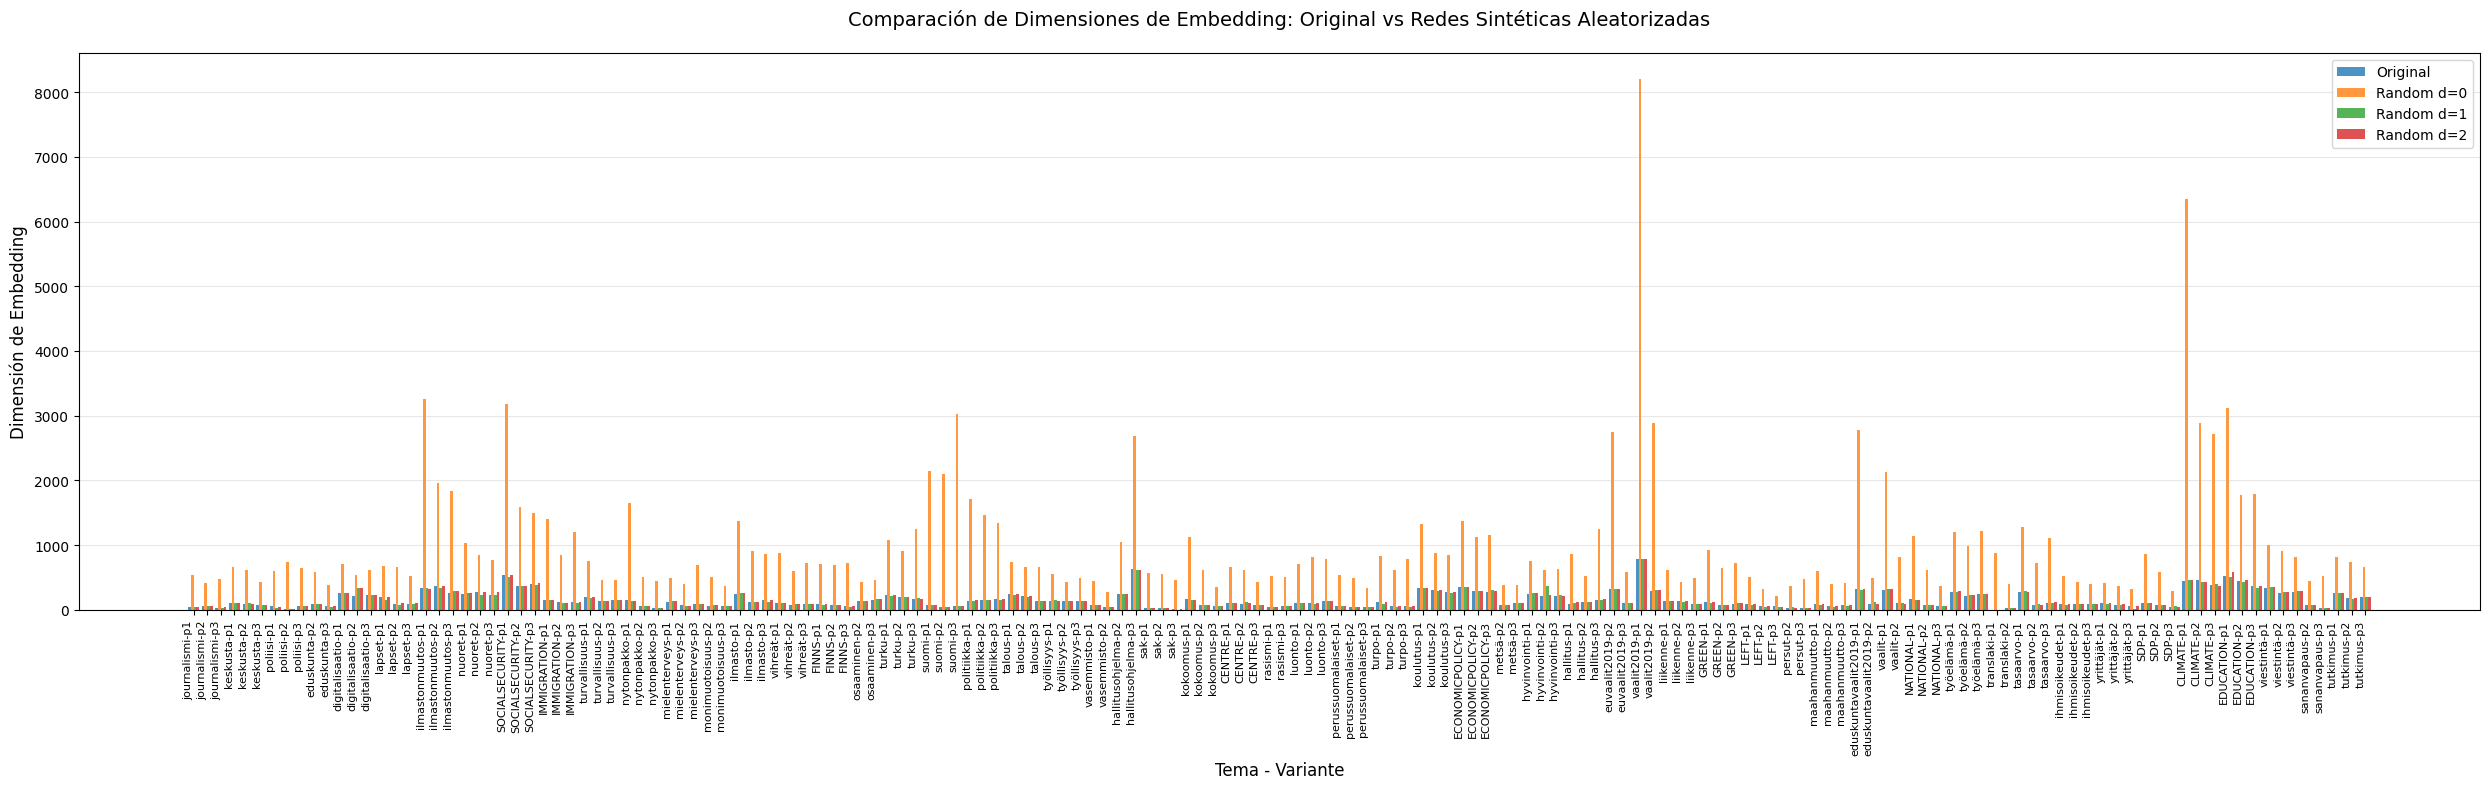


Total de redes analizadas: 160

Estadísticas descriptivas por tipo de red:
         original          d0          d1          d2
count  160.000000   160.00000  160.000000  160.000000
mean   158.631250   989.08125  157.887500  161.618750
std    127.153036   971.78282  129.707411  129.711236
min      1.000000   217.00000    1.000000    1.000000
25%     71.000000   498.75000   69.750000   72.750000
50%    111.000000   680.00000  109.500000  113.500000
75%    225.750000  1086.75000  230.250000  237.250000
max    793.000000  8198.00000  791.000000  792.000000


In [8]:
# Convert data to DataFrame for easier plotting
df_synthetic = pd.DataFrame(data, columns=['theme', 'variant', 'original', 'd0', 'd1', 'd2'])

# Create a combined label for theme-variant
df_synthetic['label'] = df_synthetic['theme'] + '-' + df_synthetic['variant']

# Set up the figure
plt.figure(figsize=(25, 8))

# Set the width of bars and positions
bar_width = 0.2
x_pos = np.arange(len(df_synthetic))

# Create bars for each dimension type
plt.bar(x_pos - 1.5*bar_width, df_synthetic['original'], bar_width, label='Original', alpha=0.8)
plt.bar(x_pos - 0.5*bar_width, df_synthetic['d0'], bar_width, label='Random d=0', alpha=0.8)
plt.bar(x_pos + 0.5*bar_width, df_synthetic['d1'], bar_width, label='Random d=1', alpha=0.8)
plt.bar(x_pos + 1.5*bar_width, df_synthetic['d2'], bar_width, label='Random d=2', alpha=0.8)

# Customize the plot
plt.xlabel('Tema - Variante', fontsize=12)
plt.ylabel('Dimensión de Embedding', fontsize=12)
plt.title('Comparación de Dimensiones de Embedding: Original vs Redes Sintéticas Aleatorizadas', fontsize=14, pad=20)
plt.xticks(x_pos, df_synthetic['label'], rotation=90, ha='right', fontsize=8)
plt.legend(fontsize=10, loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTotal de redes analizadas: {len(df_synthetic)}")
print(f"\nEstadísticas descriptivas por tipo de red:")
print(df_synthetic[['original', 'd0', 'd1', 'd2']].describe())